In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import prep

In [2]:
df = pd.read_csv('new_car_sales.csv')

In [3]:
train, test = prep.train_test_split(df)

In [4]:
train.shape, test.shape

((26, 2), (11, 2))

In [13]:
train.set_index("Year").sort_index()

,total_production
Year,
1960-01-01,7894
1965-01-01,11114
1970-01-01,8263
1975-01-01,8965
1980-01-01,8011
1985-01-01,11638
1990-01-01,9767
1991-01-01,8790
1992-01-01,9691


In [7]:
from sklearn.model_selection import cross_validate

In [9]:

import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


In [14]:
tscv = TimeSeriesSplit(n_splits = 4)
rmse = []
for train_index, test_index in tscv.split(df):
    cv_train, cv_test = df.iloc[train_index], df.iloc[test_index]
    model = ARMA(cv_train.value, order=(0, 1)).fit()
    predictions = model.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.value
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))

AttributeError: 'DataFrame' object has no attribute 'value'

In [16]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.total_production.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.041995
p-value: 0.268468


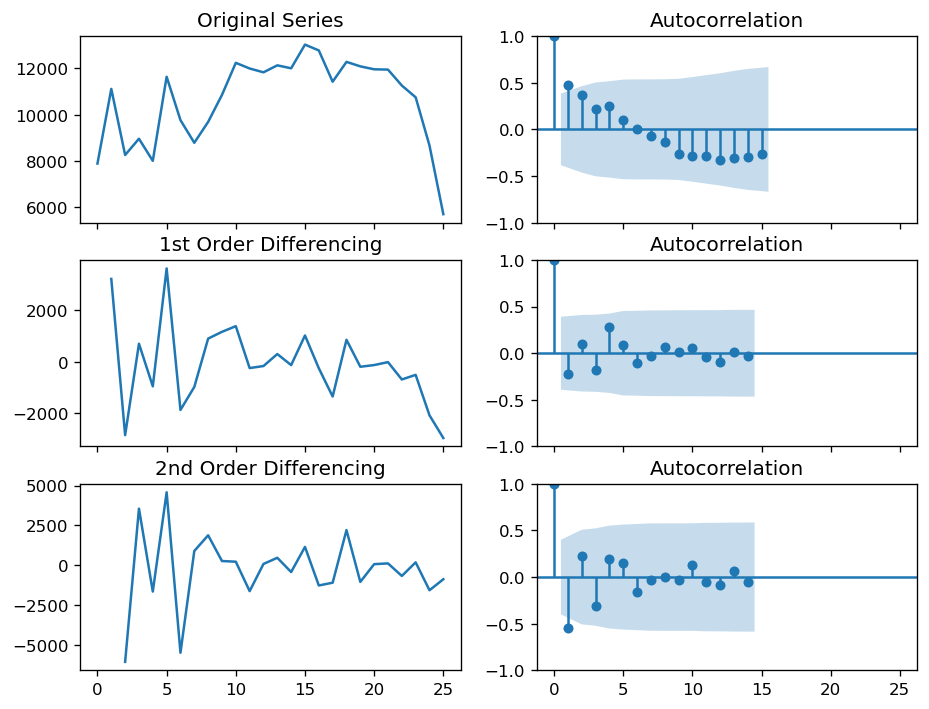

In [18]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})



# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train.total_production); axes[0, 0].set_title('Original Series')
plot_acf(train.total_production, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.total_production.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.total_production.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.total_production.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.total_production.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.
For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

In [22]:
from pmdarima.arima.utils import ndiffs

y = df.total_production

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

1

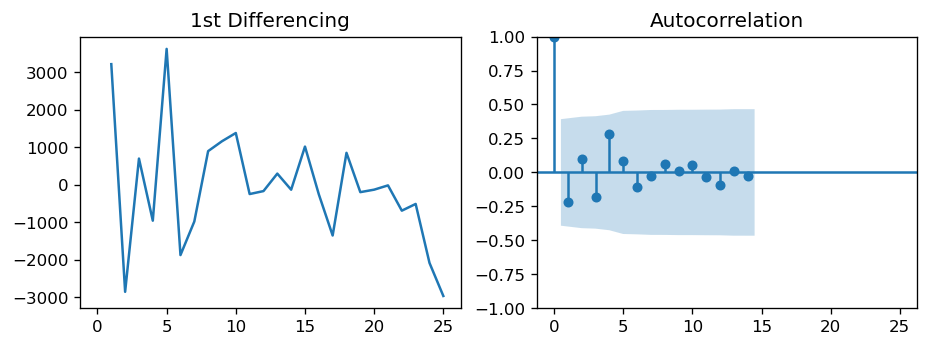

In [23]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})



fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.total_production.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train.total_production.diff().dropna(), ax=axes[1])

plt.show()

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train.total_production, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       total_production   No. Observations:                   26
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -218.577
Date:                Thu, 15 Sep 2022   AIC                            443.155
Time:                        15:31:44   BIC                            446.811
Sample:                             0   HQIC                           444.169
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8996      0.129     -6.990      0.000      -1.152      -0.647
ma.L1          1.0000      0.263      3.797      0.000       0.484       1.516
sigma2      2.303e+06   1.14e-07   2.01e+13      0.0

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


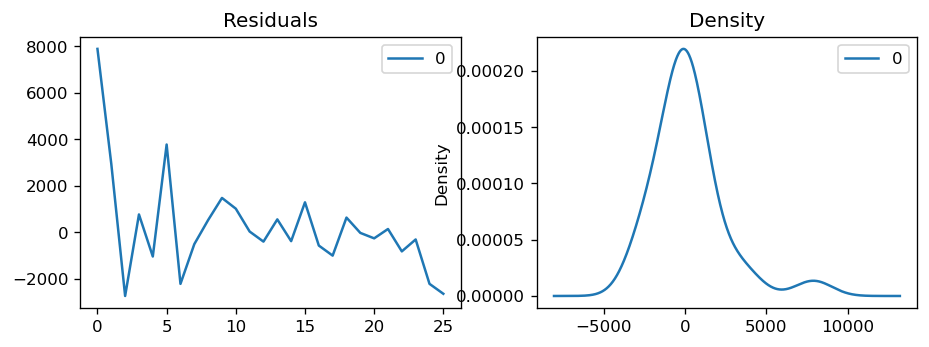

In [28]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

<AxesSubplot:>

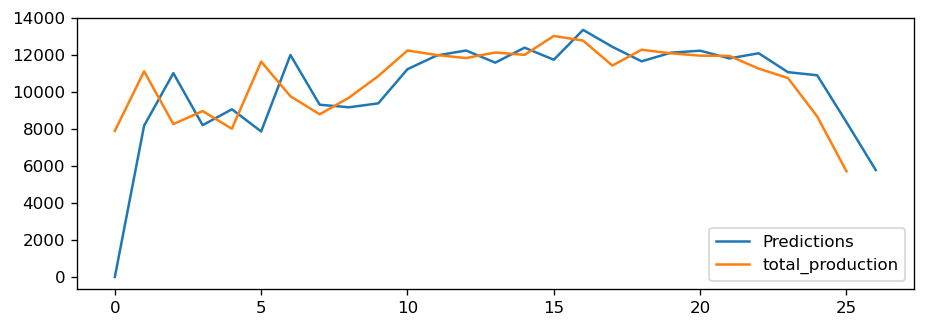

In [38]:
start = 0
end = len(train)
  
# Predictions for one-year against the test set
predictions = model_fit.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
train['total_production'].plot(legend = True)